![tracker](https://us-central1-vertex-ai-mlops-369716.cloudfunctions.net/pixel-tracking?path=statmike%2Fvertex-ai-mlops%2FApplied+GenAI%2FRanking&file=Vertex+AI+Agent+Builder+Ranking+API.ipynb)
<!--- header table --->
<table align="left">
  <td style="text-align: center">
    <a href="https://colab.research.google.com/github/statmike/vertex-ai-mlops/blob/main/Applied%20GenAI/Ranking/Vertex%20AI%20Agent%20Builder%20Ranking%20API.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/colab-logo-32px.png" alt="Google Colaboratory logo">
      <br>Run in<br>Colab
    </a>
  </td>
  <td style="text-align: center">
    <a href="https://console.cloud.google.com/vertex-ai/colab/import/https%3A%2F%2Fraw.githubusercontent.com%2Fstatmike%2Fvertex-ai-mlops%2Fmain%2FApplied%2520GenAI%2FRanking%2FVertex%2520AI%2520Agent%2520Builder%2520Ranking%2520API.ipynb">
      <img width="32px" src="https://lh3.googleusercontent.com/JmcxdQi-qOpctIvWKgPtrzZdJJK-J3sWE1RsfjZNwshCFgE_9fULcNpuXYTilIR2hjwN" alt="Google Cloud Colab Enterprise logo">
      <br>Run in<br>Colab Enterprise
    </a>
  </td>      
  <td style="text-align: center">
    <a href="https://github.com/statmike/vertex-ai-mlops/blob/main/Applied%20GenAI/Ranking/Vertex%20AI%20Agent%20Builder%20Ranking%20API.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/github-logo-32px.png" alt="GitHub logo">
      <br>View on<br>GitHub
    </a>
  </td>
  <td style="text-align: center">
    <a href="https://console.cloud.google.com/vertex-ai/workbench/deploy-notebook?download_url=https://raw.githubusercontent.com/statmike/vertex-ai-mlops/main/Applied%20GenAI/Ranking/Vertex%20AI%20Agent%20Builder%20Ranking%20API.ipynb">
      <img src="https://lh3.googleusercontent.com/UiNooY4LUgW_oTvpsNhPpQzsstV5W8F7rYgxgGBD85cWJoLmrOzhVs_ksK_vgx40SHs7jCqkTkCk=e14-rj-sc0xffffff-h130-w32" alt="Vertex AI logo">
      <br>Open in<br>Vertex AI Workbench
    </a>
  </td>
</table>

# Vertex AI Agent Builder Ranking API

This notebook explores how to leverage the [Ranking API](https://cloud.google.com/generative-ai-app-builder/docs/ranking) within [Vertex AI Agent Builder Grounding APIs](https://cloud.google.com/generative-ai-app-builder/docs/builder-apis) to enhance the accuracy and efficiency of a Retrieval-Augmented Generation (RAG) system.

In RAG, providing relevant context to a Large Language Model (LLM) is crucial for generating accurate and grounded responses. While traditional embedding-based retrieval methods are effective for finding semantically similar content, they may not always pinpoint the most relevant information. This can lead to increased costs and potentially off-topic responses.

**Why Ranking Matters:**

- Accuracy: Embedding methods (bi-encoders) excel at speed and scalability by independently encoding the query and candidate chunks. However, cross-encoders, which jointly encode the query and chunk, offer superior accuracy in assessing relevance.
- Efficiency: While cross-encoders are more accurate, they can be computationally expensive for large datasets.

The Ranking API offers a practical solution by combining the strengths of both approaches. It allows us to first retrieve potentially relevant chunks using efficient embedding methods and then re-rank those chunks with a powerful cross-encoder for optimal accuracy.

In this notebook, we'll demonstrate how to:

- Utilize the Ranking API within a RAG workflow.
- Improve the precision of your LLM's responses.
- Optimize cost-efficiency by focusing on the most pertinent information.

**Related Resources:**

For a deeper dive into the mathematics behind similarity matching and embedding methods, check out the companion notebook: [The Math of Similarity](../Embeddings/The%20Math%20of%20Similarity.ipynb).

**References:**

- [Discoveryengine Python Ranking Service Client](https://cloud.google.com/python/docs/reference/discoveryengine/latest/google.cloud.discoveryengine_v1.services.rank_service)

---
## Colab Setup

To run this notebook in Colab run the cells in this section.  Otherwise, skip this section.

This cell will authenticate to GCP (follow prompts in the popup).

In [60]:
PROJECT_ID = 'statmike-mlops-349915' # replace with project ID

In [61]:
try:
    import google.colab
    from google.colab import auth
    auth.authenticate_user()
    !gcloud config set project {PROJECT_ID}
except Exception:
    pass

---
## Installs

The list `packages` contains tuples of package import names and install names.  If the import name is not found then the install name is used to install quitely for the current user.

In [62]:
# tuples of (import name, install name, min_version)
packages = [
    ('google.cloud.aiplatform', 'google-cloud-aiplatform', '1.66.0'),
    ('google.cloud.discoveryengine', 'google-cloud-discoveryengine')
]

import importlib
install = False
for package in packages:
    if not importlib.util.find_spec(package[0]):
        print(f'installing package {package[1]}')
        install = True
        !pip install {package[1]} -U -q --user
    elif len(package) == 3:
        if importlib.metadata.version(package[0]) < package[2]:
            print(f'updating package {package[1]}')
            install = True
            !pip install {package[1]} -U -q --user

### API Enablement

In [63]:
!gcloud services enable aiplatform.googleapis.com
!gcloud services enable discoveryengine.googleapis.com

### Restart Kernel (If Installs Occured)

After a kernel restart the code submission can start with the next cell after this one.

In [64]:
if install:
    import IPython
    app = IPython.Application.instance()
    app.kernel.do_shutdown(True)
    IPython.display.display(IPython.display.Markdown("""<div class=\"alert alert-block alert-warning\">
        <b>⚠️ The kernel is going to restart. Please wait until it is finished before continuing to the next step. The previous cells do not need to be run again⚠️</b>
        </div>"""))

---
## Setup

inputs:

In [65]:
project = !gcloud config get-value project
PROJECT_ID = project[0]
PROJECT_ID

'statmike-mlops-349915'

In [66]:
REGION = 'us-central1'
SERIES = 'applied-genai'
EXPERIMENT = 'ranking-api'

packages:

In [67]:
import os, shutil, json

import numpy as np
import matplotlib.pyplot as plt

import google.cloud.discoveryengine_v1 as discoveryengine
from google.cloud import aiplatform
import vertexai.generative_models # for Gemini Models
import vertexai.language_models # for text embedding models

In [68]:
aiplatform.__version__

'1.69.0'

In [69]:
discoveryengine.__version__

'0.12.3'

clients:

In [70]:
# Vertex AI
vertexai.init(project = PROJECT_ID, location = REGION)

# Vertex AI Agent Builder APIs
ranker = discoveryengine.RankServiceClient()

---
## Text & Embeddings For Examples

This repository contains a [section for document processing (chunking)](../Chunking/readme.md) that includes an [example of processing a PDF with the Document AI Layout Parser](../Chunking/Process%20Documents%20-%20Document%20AI%20Layout%20Parser.ipynb).  The chunks of text from that workflow are stored with this repository and loaded by another companion workflow that augments the chunks with text embeddings: [Vertex AI Text Embeddings API](../Embeddings/Vertex%20AI%20Text%20Embeddings%20API.ipynb).

The following code will load the version of the chunks that includes text embeddings and prepare it for a local example of retrival augmented generation.

### Get The Documents

If you are working from a clone of this notebooks [repository](https://github.com/statmike/vertex-ai-mlops) then the documents are already present. The following cell checks for the documents folder and if it is missing gets it (`git clone`):

In [71]:
local_dir = '../Embeddings/files/embeddings-api'

In [72]:
if not os.path.exists(local_dir):
    print('Retrieving documents...')
    parent_dir = os.path.dirname(local_dir)
    temp_dir = os.path.join(parent_dir, 'temp')
    if not os.path.exists(temp_dir):
        os.makedirs(temp_dir)
    !git clone https://www.github.com/statmike/vertex-ai-mlops {temp_dir}/vertex-ai-mlops
    shutil.copytree(f'{temp_dir}/vertex-ai-mlops/Applied GenAI/Embeddings/files/embeddings-api', local_dir)
    shutil.rmtree(temp_dir)
    print(f'Documents are now in folder `{local_dir}`')
else:
    print(f'Documents Found in folder `{local_dir}`')             

Documents Found in folder `../Embeddings/files/embeddings-api`


### Load The Chunks

In [73]:
with open(local_dir+'/chunk-embeddings.jsonl', 'r') as f:
    chunks = [json.loads(line) for line in f]

### Review A Chunk

In [74]:
chunks[0].keys()

dict_keys(['instance', 'predictions', 'status'])

In [75]:
chunks[0]['instance']['chunk_id']

'c2'

In [76]:
print(chunks[0]['instance']['content'])

# OFFICIAL BASEBALL RULES

## Official Baseball Rules 2023 Edition

### JOINT COMPETITION COMMITTEE

|-|-|-|
| Bill DeWitt | Whit Merrifield | Austin Slater |
| Jack Flaherty | Bill Miller | John Stanton, Chair |
| Tyler Glasnow | Dick Monfort | Tom Werner |
| Greg Johnson | Mark Shapiro |  |

Committee Secretary Paul V. Mifsud, Jr. Copyright © 2023 by the Office of the Commissioner of Baseball


In [77]:
chunks[0]['predictions'][0]['embeddings']['values'][0:10]

[0.008681542240083218,
 0.06999468058347702,
 0.003673204220831394,
 0.019888797774910927,
 0.016285404562950134,
 0.035664502531290054,
 0.06200747936964035,
 0.05597030743956566,
 0.0034793149679899216,
 -0.024485772475600243]

### Prepare Chunk Structure

Make a dictionary for each lookup of chunk content by chunk id:

In [78]:
content_chunks = {}
for chunk in chunks:
    content_chunks[chunk['instance']['chunk_id']] = chunk['instance']['content']

In [79]:
content_chunks['c1']

'# OFFICIAL BASEBALL RULES\n\n2023 Edition TM TM'

---
## Simple Retrieval Augmented Generation (RAG)

Embeddings can be used with math to measure similarity.  For deeper details into this checkout the companion workflow here: [The Math of Similarity](../Embeddings/The%20Math%20of%20Similarity.ipynb).  Retrieval systems handle the storage and math of similarity as a service.  For an overview of Google Cloud based solutions for retrieval check out [this companion series](../Retrieval/readme.md).

The content below motivates retrieval with the embeddings that accompany the text chunks using a local vector database with brute force matching using Numpy!

### Vector DB With Numpy

In [80]:
vector_db = [
    [
        chunk['instance']['chunk_id'],
        chunk['predictions'][0]['embeddings']['values'],
    ]
    for chunk in chunks
]
vector_index = np.array([row[1] for row in vector_db])

### Models: Embeddings, Generation

Connect to models for text embeddings and text generation:

In [81]:
embedder = vertexai.language_models.TextEmbeddingModel.from_pretrained('text-embedding-004')
llm = vertexai.generative_models.GenerativeModel("gemini-1.5-flash-001")

Define a question that is the start of our prompt to the LLM:

In [82]:
question = "What are the dimensions of a base?"

Get an ungrounded response to the question with the LLM:

In [83]:
print(llm.generate_content(question).text)

The term "base" is ambiguous and can refer to many different things depending on the context. To help me understand what you're asking, please provide more information about what kind of base you're referring to. For example:

* **Geometry:** Are you asking about the base of a geometric shape like a triangle, rectangle, or prism?
* **Chemistry:** Are you asking about a base in the context of chemistry, like a substance with a pH greater than 7?
* **Computer Science:** Are you asking about a numerical base, such as base-10 (decimal) or base-2 (binary)? 

Once you clarify what you mean by "base", I can give you a more specific answer about its dimensions. 



Get an embedding for the question to use in retrieval:

In [84]:
question_embedding = embedder.get_embeddings([question])[0].values
question_embedding[0:10]

[-0.026682045310735703,
 0.011593513190746307,
 0.028523651883006096,
 -0.0017065361607819796,
 0.01946176588535309,
 0.0031198114156723022,
 0.07915323227643967,
 -0.005078596994280815,
 -0.006295712199062109,
 0.04943541809916496]

### Retrieval: Matching With Numpy

Use dot product to calculate similarity and find matches for a query embedding.  Why dot product?  Check out the companion workflow: [The Math of Similarity](../Embeddings/The%20Math%20of%20Similarity.ipynb)

> **NOTE:**  This will calculate the similarity for all embeddings vectors stored in the local vector db which is just a Numpy array here.  This is very fast because there are <200 embeddings vectors.  As this scales it would be better to consider a solution that searches a subset of embeddings.  More details on retrieval solutions can be found in [Retrieval](../Retrieval/readme.md).

In [85]:
similarity = np.dot(question_embedding, vector_index.T)
matches = np.argsort(similarity)[-5:].tolist()
matches.reverse()
matches = [(match, similarity[match]) for match in matches]
matches

[(38, 0.5843799337008113),
 (36, 0.5724333016720691),
 (836, 0.5244194362041271),
 (40, 0.5126844935129918),
 (26, 0.5033481946111171)]

In [86]:
for m, match in enumerate(matches):
    print(f"Match {m+1} ({match[1]:.2f}) is chunk {vector_db[match[0]][0]}:\n{content_chunks[vector_db[match[0]][0]]}\n###################################################")

Match 1 (0.58) is chunk c38:
# 2.00-THE PLAYING FIELD

## 2.02 Home Base

Home base shall be marked by a five-sided slab of whitened rubber. It shall be a 17-inch square with two of the corners removed so that one edge is 17 inches long, two adjacent sides are 8\frac{1}{2} inches and the remaining two sides are 12 inches and set at an angle to make a point.
###################################################
Match 2 (0.57) is chunk c39:
# 2.00-THE PLAYING FIELD

## 2.02 Home Base

It shall be set in the ground with the point at the intersection of the lines extending from home base to first base and to third base; with the 17-inch edge facing the pitcher's plate, and the two 12-inch edges coinciding with the first and third base lines. The top edges of home base shall be beveled and the base shall be fixed in the ground level with the ground surface. (See drawing D in Appendix 2.) 3
###################################################
Match 3 (0.52) is chunk c838:
# APPENDICES

## Appen

### Generation: Q&A With Gemini Grounded With RAG

Provide the matched chunks of text along with the question as a prompt to a generative model for a grounded answer.

#### Prompt Building Function

Use the matching chunks as context for the prompt:

In [87]:
def get_prompt(question, top_n = 5):
    # get embedding for question
    question_embedding = embedder.get_embeddings([question])[0].values
    # get top_n matches:
    similarity = np.dot(question_embedding, vector_index.T)
    matches = np.argsort(similarity)[-top_n:].tolist()
    matches.reverse()
    matches = [[match, similarity[match]] for match in matches]
    # construct prompt:
    prompt = ''
    for m, match in enumerate(matches):
        prompt += f"Context {m+1}:\n{content_chunks[vector_db[match[0]][0]]}\n\n"
    prompt += f'Answer the following question using the provided contexts:\n{question}'
    
    return matches, prompt

In [88]:
matches, prompt = get_prompt(question) 
print(prompt)

Context 1:
# 2.00-THE PLAYING FIELD

## 2.02 Home Base

Home base shall be marked by a five-sided slab of whitened rubber. It shall be a 17-inch square with two of the corners removed so that one edge is 17 inches long, two adjacent sides are 8\frac{1}{2} inches and the remaining two sides are 12 inches and set at an angle to make a point.

Context 2:
# 2.00-THE PLAYING FIELD

## 2.02 Home Base

It shall be set in the ground with the point at the intersection of the lines extending from home base to first base and to third base; with the 17-inch edge facing the pitcher's plate, and the two 12-inch edges coinciding with the first and third base lines. The top edges of home base shall be beveled and the base shall be fixed in the ground level with the ground surface. (See drawing D in Appendix 2.) 3

Context 3:
# APPENDICES

## Appendix 2

Diagram No. 2 Layout at Home Plate, 1st, 2nd, and 3rd Bases 18" A 18" 90° LAYOUT AT SECOND BASE FOR LAYOUT AT PITCHER'S PLATE SEE DIAGRAM NO. 3 90° 6"

### Grounded Generation

In [89]:
answer = llm.generate_content(prompt).text
print(answer)

The dimensions of a base vary depending on the type of base:

* **Home Base:** 17 inches long, two adjacent sides are 8 1/2 inches, and the remaining two sides are 12 inches. 
* **First, Second, and Third Bases:** 18 inches square, with a thickness between 3 and 5 inches. 



---
## Ranking API

Vertex AI Agent Builder has several helpful APIs for grounding, including:
- [Ranking API](https://cloud.google.com/generative-ai-app-builder/docs/ranking)
    - Rank chunks based on relationship to a query.
    
**References:**

- [Discoveryengine Python Ranking Service Client](https://cloud.google.com/python/docs/reference/discoveryengine/latest/google.cloud.discoveryengine_v1.services.rank_service)

### Get 20 Matches By Vector Similarity

In [90]:
matches, _ = get_prompt(question, 20)

In [91]:
len(matches)

20

In [92]:
matches[0], matches[-1]

([38, 0.5843799337008113], [28, 0.4483553514768128])

### Use the Ranking API to Get The Top-5 Matches

In [93]:
rank_results = ranker.rank(
    request = discoveryengine.RankRequest(
        ranking_config = ranker.ranking_config_path(
            project = PROJECT_ID,
            location = "global",
            ranking_config = "default_ranking_config",
        ),
        model = "semantic-ranker-512@latest",
        #top_n = 5,
        query = question,
        records = [
            discoveryengine.RankingRecord(
                id = vector_db[match[0]][0],
                content = content_chunks[vector_db[match[0]][0]]
            ) for match in matches
        ]
    )
)

In [94]:
rank_results.records[0:5]

[id: "c38"
 content: "# 2.00-THE PLAYING FIELD\n\n## 2.02 Home Base\n\nHome base shall be marked by a five-sided slab of whitened rubber. It shall be a 17-inch square with two of the corners removed so that one edge is 17 inches long, two adjacent sides are 8\\frac{1}{2} inches and the remaining two sides are 12 inches and set at an angle to make a point."
 score: 0.9900000095367432,
 id: "c40"
 content: "# Rule 2.03 to 2.05\n\n## 2.03 The Bases\n\nFirst, second and third bases shall be marked by white canvas or rubber-covered bags, securely attached to the ground as indicated in Diagram 2. The first and third base bags shall be entirely within the infield. The second base bag shall be centered on second base. The bags shall be 18 inches square, not less than three nor more than five inches thick, and filled with soft material."
 score: 0.6899999976158142,
 id: "c39"
 content: "# 2.00-THE PLAYING FIELD\n\n## 2.02 Home Base\n\nIt shall be set in the ground with the point at the intersec

In [95]:
for m, match in enumerate(rank_results.records): print(f"{m+1} - chunk_id: {match.id} with distance: {match.score}")

1 - chunk_id: c38 with distance: 0.9900000095367432
2 - chunk_id: c40 with distance: 0.6899999976158142
3 - chunk_id: c39 with distance: 0.6299999952316284
4 - chunk_id: c838 with distance: 0.5
5 - chunk_id: c41 with distance: 0.4399999976158142
6 - chunk_id: c31 with distance: 0.30000001192092896
7 - chunk_id: c32 with distance: 0.25
8 - chunk_id: c837 with distance: 0.1599999964237213
9 - chunk_id: c840 with distance: 0.15000000596046448
10 - chunk_id: c839 with distance: 0.12999999523162842
11 - chunk_id: c29 with distance: 0.10999999940395355
12 - chunk_id: c28 with distance: 0.10000000149011612
13 - chunk_id: c842 with distance: 0.09000000357627869
14 - chunk_id: c42 with distance: 0.05000000074505806
15 - chunk_id: c34 with distance: 0.029999999329447746
16 - chunk_id: c23 with distance: 0.009999999776482582
17 - chunk_id: c12 with distance: 0.009999999776482582
18 - chunk_id: c30 with distance: 0.009999999776482582
19 - chunk_id: c27 with distance: 0.009999999776482582
20 - chun

### Compare Similarity To Ranking

Create a visual with the top 20 result from similarity compared to their order from the ranking API:

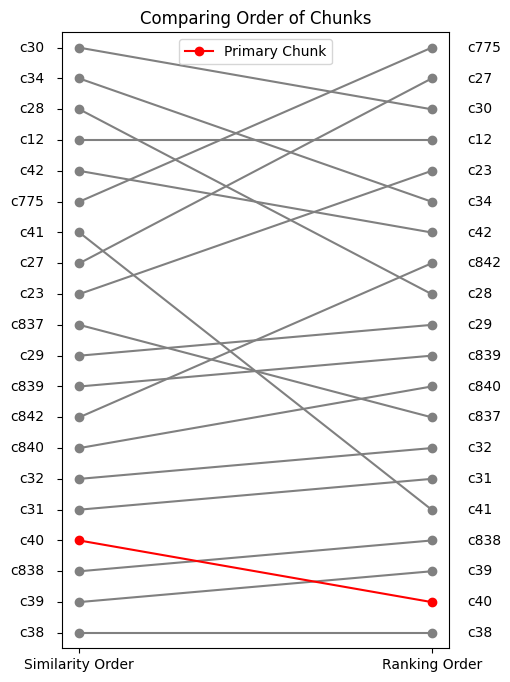

In [96]:
# Get order list of chunks by similarity and ranking
chunks_by_similarity = [vector_db[match[0]][0] for match in matches]
chunks_by_ranking = [record.id for record in rank_results.records]
n_chunks = len(chunks_by_similarity)

# Create the plot
fig, ax = plt.subplots(figsize=(5, 8))

for i in range(n_chunks):
    label = chunks_by_similarity[i]
    color = 'red' if label == 'c40' else 'gray'
    plot_label = 'Primary Chunk' if color == 'red' else None
    ax.plot([0, 1], [i, chunks_by_ranking.index(chunks_by_similarity[i])], marker='o', color=color, label=plot_label)
for i, label in enumerate(chunks_by_similarity):
    ax.text(-0.1, i, label, ha='right', va='center')
    ax.text(1.1, chunks_by_ranking.index(label), label, ha='left', va='center')

# Customize axes and labels
ax.set_xticks([0, 1])
ax.set_xticklabels(['Similarity Order', 'Ranking Order'])
ax.set_ylim(-0.5, n_chunks - 0.5)
ax.set_yticks(range(n_chunks))
#ax.set_yticklabels(chunks_by_similarity)
ax.set_yticklabels([])
ax.set_title('Comparing Order of Chunks')
ax.legend()

# Show the plot
plt.show()

### Example - Prompt With The Known Best Chunk: Correct Answer

For a baseline use the known best chunk.  In real-world situations this is not always possible but it makes a good baseline for the following examples that compare chunks retrieved from similarity and those filtered by ranking.

In [97]:
# construct prompt:
prompt = ''
prompt += f"Context {m+1}:\n{content_chunks['c40']}\n\n"
prompt += f'Answer the following question using the provided contexts:\n{question}'
print(prompt)

Context 20:
# Rule 2.03 to 2.05

## 2.03 The Bases

First, second and third bases shall be marked by white canvas or rubber-covered bags, securely attached to the ground as indicated in Diagram 2. The first and third base bags shall be entirely within the infield. The second base bag shall be centered on second base. The bags shall be 18 inches square, not less than three nor more than five inches thick, and filled with soft material.

Answer the following question using the provided contexts:
What are the dimensions of a base?


In [98]:
answer = llm.generate_content(prompt).text
print(answer)

According to Rule 2.03, the bases are 18 inches square and between 3 and 5 inches thick. 



### Example - Prompt With Top 2 Chunks By Similarity: Wrong Answer

In [99]:
# construct prompt:
prompt = ''
for m, match in enumerate(chunks_by_similarity[0:2]):
    prompt += f"Context {m+1}:\n{content_chunks[match]}\n\n"
prompt += f'Answer the following question using the provided contexts:\n{question}'
print(prompt)

Context 1:
# 2.00-THE PLAYING FIELD

## 2.02 Home Base

Home base shall be marked by a five-sided slab of whitened rubber. It shall be a 17-inch square with two of the corners removed so that one edge is 17 inches long, two adjacent sides are 8\frac{1}{2} inches and the remaining two sides are 12 inches and set at an angle to make a point.

Context 2:
# 2.00-THE PLAYING FIELD

## 2.02 Home Base

It shall be set in the ground with the point at the intersection of the lines extending from home base to first base and to third base; with the 17-inch edge facing the pitcher's plate, and the two 12-inch edges coinciding with the first and third base lines. The top edges of home base shall be beveled and the base shall be fixed in the ground level with the ground surface. (See drawing D in Appendix 2.) 3

Answer the following question using the provided contexts:
What are the dimensions of a base?


In [100]:
answer = llm.generate_content(prompt).text
print(answer)

Here are the dimensions of a base, according to the provided context:

* **One edge:** 17 inches
* **Two adjacent sides:** 8 1/2 inches
* **Two remaining sides:** 12 inches 

These dimensions create a five-sided shape with a point. 



### Example - Prompt with Top 2 Chunks By Ranking: Correct Answer

In [101]:
# construct prompt:
prompt = ''
for m, match in enumerate(chunks_by_ranking[0:2]):
    prompt += f"Context {m+1}:\n{content_chunks[match]}\n\n"
prompt += f'Answer the following question using the provided contexts:\n{question}'
print(prompt)

Context 1:
# 2.00-THE PLAYING FIELD

## 2.02 Home Base

Home base shall be marked by a five-sided slab of whitened rubber. It shall be a 17-inch square with two of the corners removed so that one edge is 17 inches long, two adjacent sides are 8\frac{1}{2} inches and the remaining two sides are 12 inches and set at an angle to make a point.

Context 2:
# Rule 2.03 to 2.05

## 2.03 The Bases

First, second and third bases shall be marked by white canvas or rubber-covered bags, securely attached to the ground as indicated in Diagram 2. The first and third base bags shall be entirely within the infield. The second base bag shall be centered on second base. The bags shall be 18 inches square, not less than three nor more than five inches thick, and filled with soft material.

Answer the following question using the provided contexts:
What are the dimensions of a base?


In [102]:
answer = llm.generate_content(prompt).text
print(answer)

The dimensions of a base depend on its type:

* **Home base:** 17 inches square with two corners removed. One edge is 17 inches, two adjacent sides are 8 1/2 inches, and the remaining two sides are 12 inches.
* **First, second, and third bases:** 18 inches square, between 3 and 5 inches thick. 

